# Intro

The purpose of this notebook is to predict sentiment of news data. This will be combined with stock history in order to try and better understand the correlation between news headlines and stock price. 


To do:
- could also do one on bitcoin (BTCUSD, ETHUSD, LTCUSD, BCHUSD, )
- could check airlines 
- oil/gas prices should also make headlines fairly frequently
- Other companies to try: Walmart (WMT) Amazon (AMZN) Google (GOOGL, GOOG) NVidia (NVDA) Tesla (TSLA) Meta (META)

https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [1]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline
import torch
from bs4 import BeautifulSoup
import re
from configs import NEWS_SAVE_FILE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Trade_Class import Stock_Trader, Crypto_Trader
from Market_Monitor import Market_Monitor
from my_secrets import ALPACA_API_BASE_URL, PAPER_API_ID, PAPER_SECRET_KEY
from datetime import datetime, timedelta
from configs import TIMEZONE, LOG_FILE_NAME, set_logger
from langdetect import detect
import random

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
set_logger()

c:\Users\mschm\Desktop\Masters_DU\Capstone_Trade_bot_project\capenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we will use a BERT model that has been trained on a "reviews" dataset. It classifies text on a scale from 1-5 with 5 being the most positive. We will apply this to our newspaper headlines.

First we load the pretrained model and tokenizer using hugging face transformers library.

In [2]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

First we use the tokenizer to tokenize the text.<br>
Then we show how you can decode the tokenizer if need be.<br>
Then we feed the tokens to the model to make a prediction.<br>
Then we take the maximum of the results and add one so we have a scale of 1-5 (instead of 0-4)

In [3]:
tokens = tokenizer.encode("I hated this, pretty bad", return_tensors='pt')
display(tokens)
display(tokenizer.decode(tokens[0]))
result = model(tokens)
display(result)
display(torch.argmax(result.logits)+1)

tensor([[  101,   151, 39487, 10163, 10372,   117, 31897, 12428,   102]])

'[CLS] i hated this, pretty bad [SEP]'

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.8734,  2.0596,  0.3354, -1.9716, -2.6467]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

tensor(1)

Now we will wrap what we have done in a function so it can be applied to our dataframe column.

In [4]:
def tokenize_and_predict(text: str):
    """
    Takes some text in string format (words separated by spaces), tokenizes it and predicts sentiment based on BERT model.
    The output is a number between 1 and 5. In order to interpret as sentiment think of it as 1 start review to 5 star review. (5 being most positive).
    """
    tokens = tokenizer.encode(text, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits)) + 1

Next we will use a more generic sentiment analyzer to analyze the sentiment and define a function to also apply to the news headlines.

In [5]:
classifier = pipeline("sentiment-analysis")
display(classifier("hi"))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9983267188072205}]

In [6]:
def sentiment_classifier(text: str):
    """
    Takes some text in string format (words separated by spaces), tokenizes it and predicts sentiment.
    Return will either be 'NEGATIVE' or 'POSITIVE'.
    """

    result = classifier(text)[0]
    if result['label']=="NEGATIVE":
        return -1*result['score']
    else:
        return result['score']

For our third way of analyzing sentiment we be using Vader sentiment analysis. Again we just instantiate the model and then retrieve the polarity scores dictionary for each text. 

We will again wrap this in a function so we can apply to dataframe. We will just grab the compound score.

In [7]:
vader = SentimentIntensityAnalyzer()

display(vader.polarity_scores("I am very happy!"))
display(vader.polarity_scores("I am very sad."))

{'neg': 0.0, 'neu': 0.412, 'pos': 0.588, 'compound': 0.6468}

{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'compound': -0.5256}

In [8]:
def vader_prediction(text: str):
    return vader.polarity_scores(text)['compound']

Now we read in our data scraped from news websites through our news scraping app.

In [9]:
df = pd.read_pickle(NEWS_SAVE_FILE)
print(df.shape)
df.sample(2)

(18577, 9)


,headline,publish_date,content,authors,keywords,summary,source,url,date_pulled
1863,Macron under fire as French protests turn viol...,NaT,French President Emmanuel Macron is refusing t...,[Paul Best],"[turn, protesters, 4prev, age, lived, streets,...",French President Emmanuel Macron is refusing t...,foxnews,https://www.foxnews.com/,03-23-23
8737,"Japan, US agree to cooperate on geothermal energy",NaT,Japan and the United States have agreed to coo...,[Abc News],"[power, capacity, united, generating, cooperat...",Japan and the United States have agreed to coo...,abcnews.go,https://abcnews.go.com/,04-16-23


## Filter so we are only working with english headlines

In [10]:
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [11]:
#takes 2 mins to run
df['language'] = df['headline'].apply(detect_language)

In [12]:
df = df[df['language']=='en']
df.reset_index(inplace=True, drop=True)

In [13]:
#takes 11 minutes to run
df['BERT_headline_review'] = df['headline'].apply(tokenize_and_predict)

In [14]:
#takes 5 minutes to run
df['headline_sentiment'] = df['headline'].apply(sentiment_classifier)

In [15]:
#takes 0 minutes to run 
df['vader_sentiment'] = df['headline'].apply(vader_prediction)

In [16]:
df[['BERT_headline_review', 'headline_sentiment', 'vader_sentiment']].sample(20)

,BERT_headline_review,headline_sentiment,vader_sentiment
116,5,-0.616610,0.0000
6177,5,-0.989339,-0.2960
3322,1,-0.998755,-0.4019
2442,1,0.685450,0.0000
11313,4,0.999027,0.0000
9032,5,-0.950058,0.0000
6277,1,-0.999092,-0.1280
1607,4,0.909480,-0.3612
2417,1,-0.944692,0.0772
282,1,-0.980947,-0.2960


# Analysis of sentiment scores

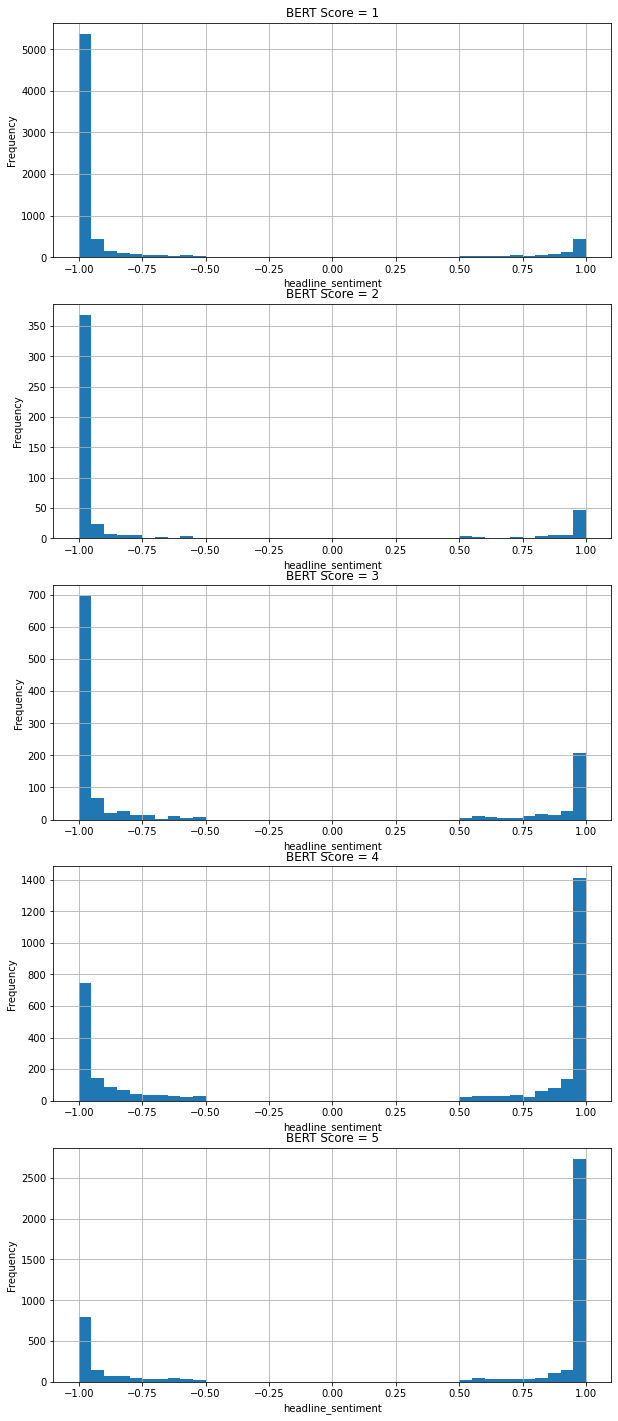

In [17]:
fig, axes = plt.subplots(nrows=len(df['BERT_headline_review'].unique()), ncols=1, figsize=(10, 25))

# iterate over unique values of 'x' and create a histogram for each one
for i, x_val in enumerate(sorted(df['BERT_headline_review'].unique())):
    df[df['BERT_headline_review'] == x_val]['headline_sentiment'].plot.hist(ax=axes[i], title=f'BERT Score = {x_val}', bins=40)
    axes[i].set_xlabel('headline_sentiment')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

<Axes: >

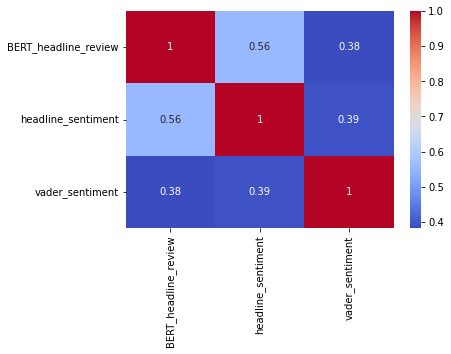

In [18]:
corr_matrix = df[['BERT_headline_review', 'headline_sentiment', 'vader_sentiment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Wordclouds

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mschm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def series_to_freq_dict(series, stop_words, stemmer):
    text = ' '.join(series)
    words = [word for word in text.split() if word.lower() not in stop_words]

    stems = [stemmer.stem(word) for word in words]

    word_freq = dict(Counter(stems))
    
    word_freq = {k: v for k, v in word_freq.items() if k.isalnum()} # remove any non-alphanumeric characters from the keys of the dictionary

    # convert the dictionary to a pandas series and sort by frequency
    word_freq_series = pd.Series(word_freq)
    word_freq_series = word_freq_series.sort_values(ascending=False)

    # convert the pandas series to a numpy array
    word_freq_array = np.array(word_freq_series)

    # create a dictionary mapping each word to its frequency
    word_freq_dict = dict(zip(word_freq_series.index, word_freq_array))

    return word_freq_dict

In [21]:
def plot_wordcloud(freq_dict):
    wordcloud = WordCloud(width=800, height=400, background_color='white')

    # generate the word cloud
    wordcloud.generate_from_frequencies(freq_dict)

    # plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

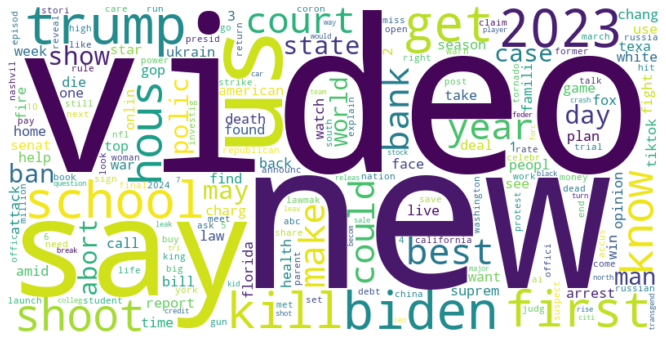

In [22]:
freq_dict = series_to_freq_dict(df['headline'], stop_words, stemmer)
plot_wordcloud(freq_dict)

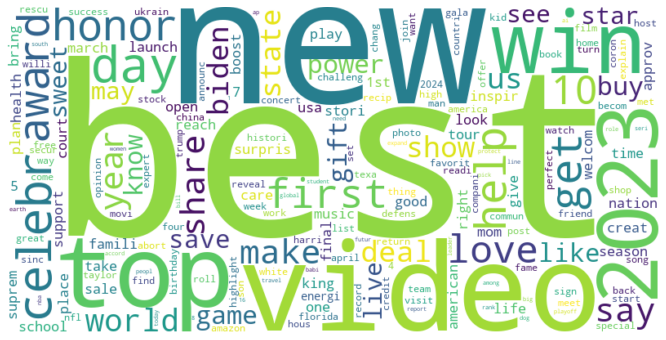

In [23]:
#['BERT_headline_review', 'headline_sentiment', 'vader_sentiment']
df['positivie_series'] = (df['BERT_headline_review']>3) & (df['headline_sentiment']>0) & (df['vader_sentiment']>0)
positivie_series = df[df['positivie_series']]['headline']
freq_dict = series_to_freq_dict(positivie_series, stop_words, stemmer)
plot_wordcloud(freq_dict)

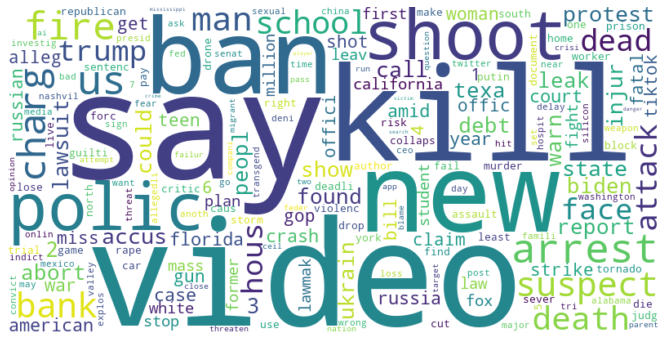

In [24]:
df['negative_series'] = (df['BERT_headline_review']<3) & (df['headline_sentiment']<0) & (df['vader_sentiment']<0)
negative_series = df[df['negative_series']]['headline']
freq_dict = series_to_freq_dict(negative_series, stop_words, stemmer)
plot_wordcloud(freq_dict)

In [25]:
na_total = df['publish_date'].isna().sum() #count NA for datetime column
print(f"NaT count: {na_total:,}/{df.shape[0]:,}")

NaT count: 7,532/16,517


In [26]:
df = df[~df['publish_date'].isna()] #drop NA values for publish datetime column
df.reset_index(inplace=True, drop=True)

In [27]:
def is_timezone_aware(dt):
    """
    Returns True if the datetime object is timezone aware, False otherwise.
    """
    return dt.tzinfo is not None

In [28]:
df['publish_date'].apply(is_timezone_aware).sum() #count the number of rows that are timezone aware

1138

In [29]:
def remove_timezone(dt):
    """
    Returns a timezone naive datetime object by removing the timezone information
    from the input datetime object. If the input datetime object is already timezone
    naive, the function returns it as is.
    """
    if dt.tzinfo is not None:
        # remove timezone information if it is timezone aware
        dt = dt.replace(tzinfo=None)
    return dt

In [30]:
df['publish_date'] = df['publish_date'].apply(remove_timezone) #remove timezone awareness

In [31]:
df['publish_date'].apply(is_timezone_aware).sum() #recount to make sure it worked

0

In [32]:
df['publish_date'] = pd.to_datetime(df['publish_date'])

In [33]:
df['publish_date'].min(), df['publish_date'].max()

(Timestamp('2010-06-22 00:00:00'), Timestamp('2023-05-05 00:00:00'))

In [34]:
earliest_date = datetime(year=2023, month=4, day=1, hour=0, minute=0, second=0) #choosing the earliest date

In [35]:
#filter dataframe by earliest date
df = df[df['publish_date']>earliest_date]
df.reset_index(inplace=True, drop=True)

<Axes: >

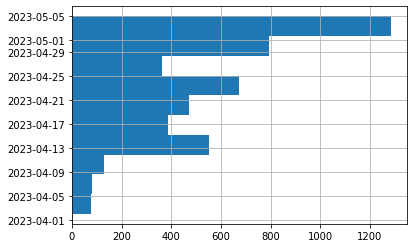

In [36]:
df['publish_date'].hist(orientation='horizontal')

In [51]:
df['positivie_series'].sum(), df['negative_series'].sum()

(647, 1046)

In [37]:
stock_trader = Stock_Trader(PAPER_API_ID, PAPER_SECRET_KEY, paper=True)
monitor = Market_Monitor(stock_trader.trading_client, TIMEZONE)

In [39]:
tech_words = [
    'Apple',
    'Microsoft',
    'Tech',
    'Technology',
    'Tech',
    'Phone',
    'Smart',
    'Artificial Intelligence',
    'AI',
    'Machine Learning',
    'Computer',
    'CPU',
    'GPU',
    'Mac',
    'PC',
    'Hack',
    'Metaverse',
    'Meta',
    'Facebook',
    'NFT',
    'Web3',
    'Virtual Reality',
    'Augmented Reality',
    'Micron',
    'program',
    'Extended Reality',
    'Cloud',
    'computing',
    'automate',
    'digital'
]

In [48]:
def plot_stock_sentiment(bars_df, sentiment_df, stock_name, stock_type='close'):

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(bars_df['timestamp'], bars_df[stock_type].values, label=f'{stock_type} Prices', linewidth=2.5)
    ax.fill_between(bars_df['timestamp'], bars_df[stock_type].values.min(), bars_df[stock_type].values, alpha=.3)

    ax.tick_params(axis='x', rotation=45)

    for index, row in sentiment_df[sentiment_df['positivie_series']].iterrows():
        ax.axvline(x=row['publish_date'], color='green', linestyle='--')

    for index, row in sentiment_df[sentiment_df['negative_series']].iterrows():
        ax.axvline(x=row['publish_date'], color='red', linestyle='--')

    ax.set_title(f"{stock_name} Close Prices")
    ax.set_ylabel("Price ($)")
    ax.set_xlabel("Date")

In [41]:
def pull_stock_analyze_sentiment(symbol, full_name, search_words, sentiment_df, n_print=5):
    """ 
    symbol: ticker symbol of stock. ie 'AAPL'
    full_name: regular company name. id 'apple'
    full headline sentiment df.
    """
    end = df['publish_date'].max().to_pydatetime()
    bars_df = stock_trader.get_bars(symbol, start=earliest_date - timedelta(days=5), end=end, time_resolution='day')
    bars_df.reset_index(inplace=True)
    bars_df.sort_values(by=['timestamp'], ascending=True, inplace=True)
    print(bars_df.shape)
    display(bars_df.head())

    def search_func(text, search_words):
        text = text.lower()
        for word in search_words:
            if word.lower() in text:
                return True
        return False

    sentiment_df[f'is_{full_name}'] = sentiment_df['headline'].apply(lambda x: search_func(x, search_words))
    symbol_df = sentiment_df[sentiment_df[f'is_{full_name}']]
    symbol_df.reset_index(inplace=True, drop=True)

    print()
    print("********Positive Headlines***********")
    pos_list = symbol_df[symbol_df['positivie_series']]['headline'].tolist()
    if len(pos_list)>n_print:
        pos_list = random.sample(pos_list, n_print)
    for h in pos_list:
        print(h)
    print()
    print("*********Negative Headlines**********")
    neg_list = symbol_df[symbol_df['negative_series']]['headline'].tolist()
    if len(neg_list)>n_print:
        neg_list = random.sample(neg_list, n_print)
    for h in neg_list:
        print(h)

    plot_stock_sentiment(bars_df, symbol_df, full_name)

(28, 9)


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,NDAQ,2023-03-27 04:00:00+00:00,53.61,53.700,53.120,53.25,1330149.0,19882.0,53.281581
1,NDAQ,2023-03-28 04:00:00+00:00,53.00,53.235,52.630,52.94,2570484.0,23133.0,52.905345
2,NDAQ,2023-03-29 04:00:00+00:00,53.47,54.280,53.350,54.09,2123570.0,26865.0,53.931383
3,NDAQ,2023-03-30 04:00:00+00:00,54.32,54.790,53.945,54.03,2599682.0,32122.0,54.216248
4,NDAQ,2023-03-31 04:00:00+00:00,54.37,54.700,54.030,54.66,2229383.0,32145.0,54.312706



********Positive Headlines***********
Sergio Pérez Wins as Red Bull Dominates Again
Microsoft’s current AI dominance is thrilling the company’s diehard fans
Vatican No 2 confirms Russia-Ukraine peace mission plans
Dubai's stunning skyline shown in surreal, dramatic images
Updated daily: Here are the 10 best Amazon deals on Vitamix, iRobot and Blink

*********Negative Headlines**********
Russia alleges Ukraine tried to attack the Kremlin in a Putin assassination attempt
The Bud Light boycott over trans influencer Dylan Mulvaney, explained
Fire in Dubai kills 16, injures 9 in apartment building
Beef’s sexual assault controversy, explained
Why Criminal Charges Were Dropped Against Alec Baldwin in Movie Shooting


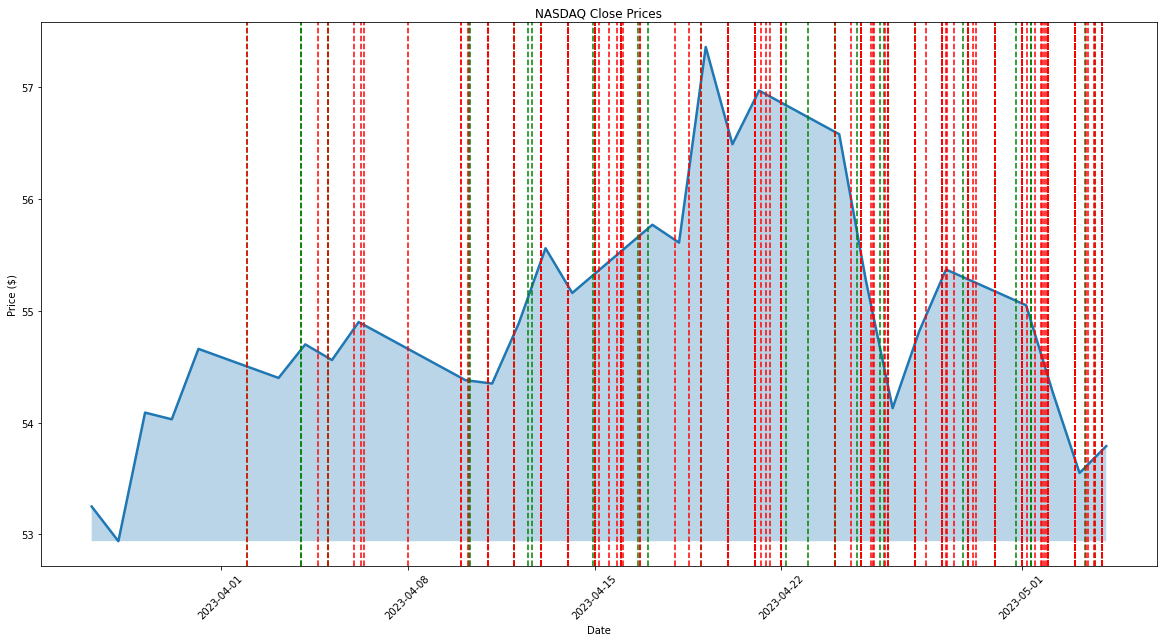

In [49]:
pull_stock_analyze_sentiment('NDAQ', 'NASDAQ', tech_words, df)

(28, 9)


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,AAPL,2023-03-27 04:00:00+00:00,159.94,160.77,157.870,158.28,52405692.0,519169.0,159.018597
1,AAPL,2023-03-28 04:00:00+00:00,157.97,158.49,155.980,157.65,46007145.0,433125.0,156.978720
2,AAPL,2023-03-29 04:00:00+00:00,159.37,161.05,159.350,160.77,51328230.0,472820.0,160.216097
3,AAPL,2023-03-30 04:00:00+00:00,161.53,162.47,161.271,162.36,49502003.0,456154.0,162.020525
4,AAPL,2023-03-31 04:00:00+00:00,162.44,165.00,161.910,164.76,55959943.0,568687.0,163.851052



********Positive Headlines***********
Apple Music Classical aims to reach music lovers the streaming revolution left behind
10 best Amazon deals: Apple, Cuisinart and Otterbox

*********Negative Headlines**********
How do I stop Apple from showing my location? Halt Google, others, from seeing your data
The problem with Apple’s big banking push
Apple AirPods are 38% off at Amazon—get the earbuds for one of the lowest prices we've seen


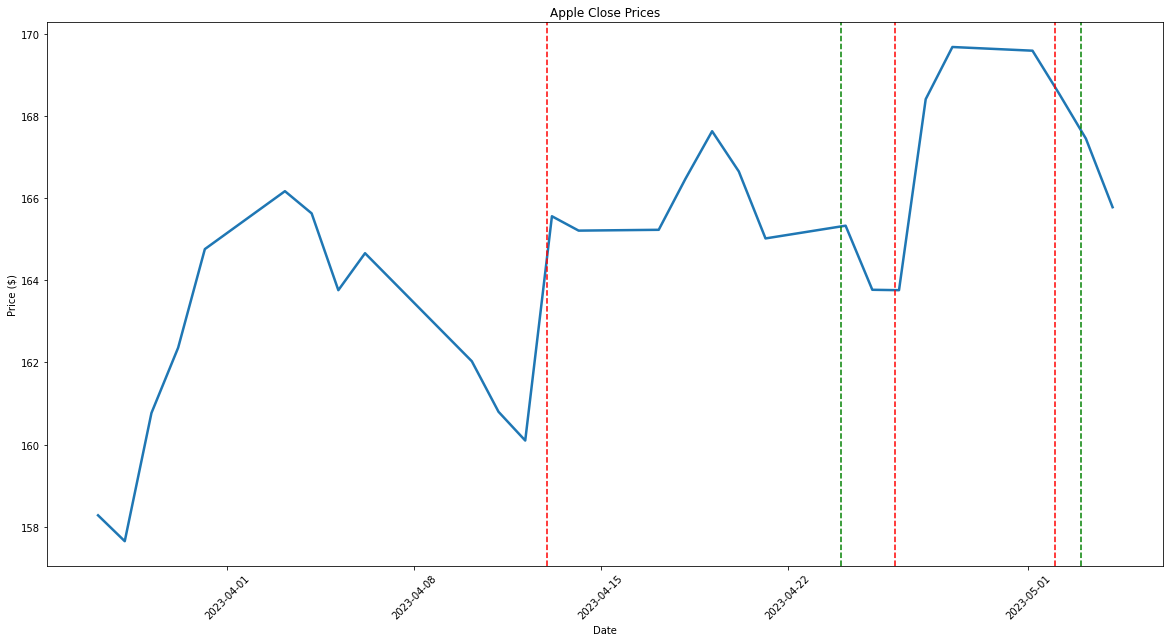

In [43]:
pull_stock_analyze_sentiment('AAPL', 'Apple', ['apple'], df)

(28, 9)


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,MSFT,2023-03-27 04:00:00+00:00,280.50,281.4589,275.5200,276.38,26849497.0,337265.0,277.622716
1,MSFT,2023-03-28 04:00:00+00:00,275.79,276.1400,272.0451,275.23,21883950.0,288597.0,273.833311
2,MSFT,2023-03-29 04:00:00+00:00,278.96,281.1398,278.4100,280.51,25096698.0,312944.0,279.895658
3,MSFT,2023-03-30 04:00:00+00:00,284.23,284.4600,281.4800,284.05,25053410.0,338299.0,283.178802
4,MSFT,2023-03-31 04:00:00+00:00,283.73,288.8200,283.0000,288.30,26149167.0,394979.0,286.069572



********Positive Headlines***********
Microsoft’s current AI dominance is thrilling the company’s diehard fans
Microsoft reports boost in profits, revenue, as it pushes AI

*********Negative Headlines**********


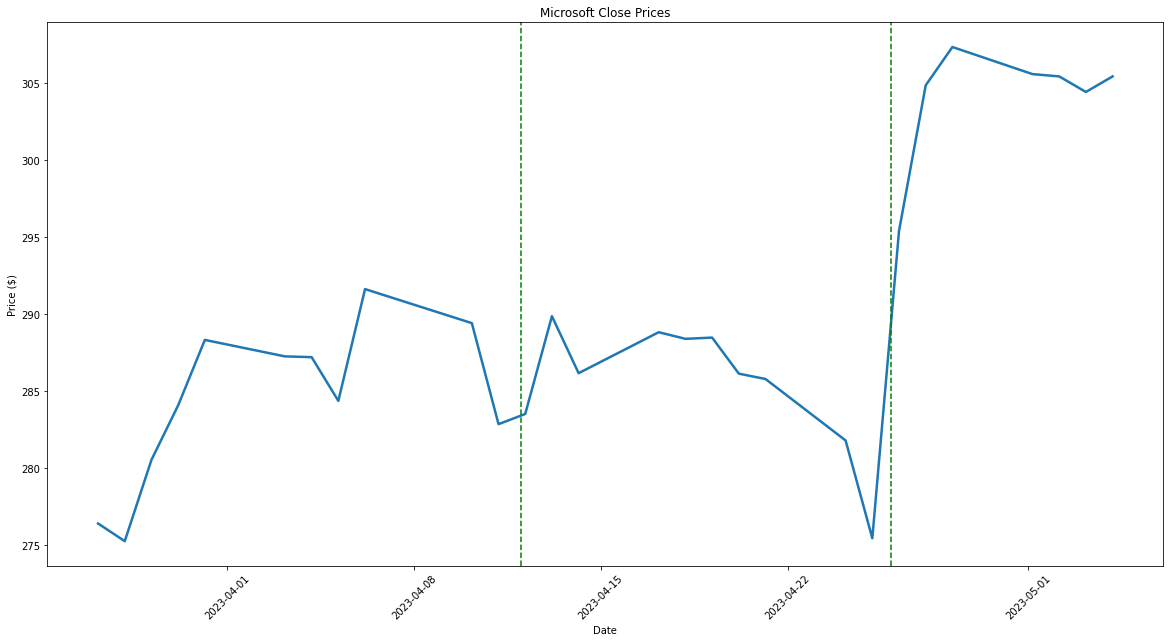

In [44]:
pull_stock_analyze_sentiment('MSFT', 'Microsoft', ['microsoft', 'msft', 'windows'], df)

(28, 9)


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,MU,2023-03-27 04:00:00+00:00,61.19,61.4200,59.1701,59.79,15902533.0,141043.0,60.072871
1,MU,2023-03-28 04:00:00+00:00,59.80,59.8700,57.8150,59.28,20629656.0,178991.0,58.928682
2,MU,2023-03-29 04:00:00+00:00,60.91,64.4200,60.8700,63.54,51953778.0,369750.0,63.080588
3,MU,2023-03-30 04:00:00+00:00,64.03,64.1000,62.4800,63.09,23038346.0,159268.0,63.081804
4,MU,2023-03-31 04:00:00+00:00,60.35,61.6582,59.9000,60.32,32803717.0,250836.0,60.854840



********Positive Headlines***********

*********Negative Headlines**********


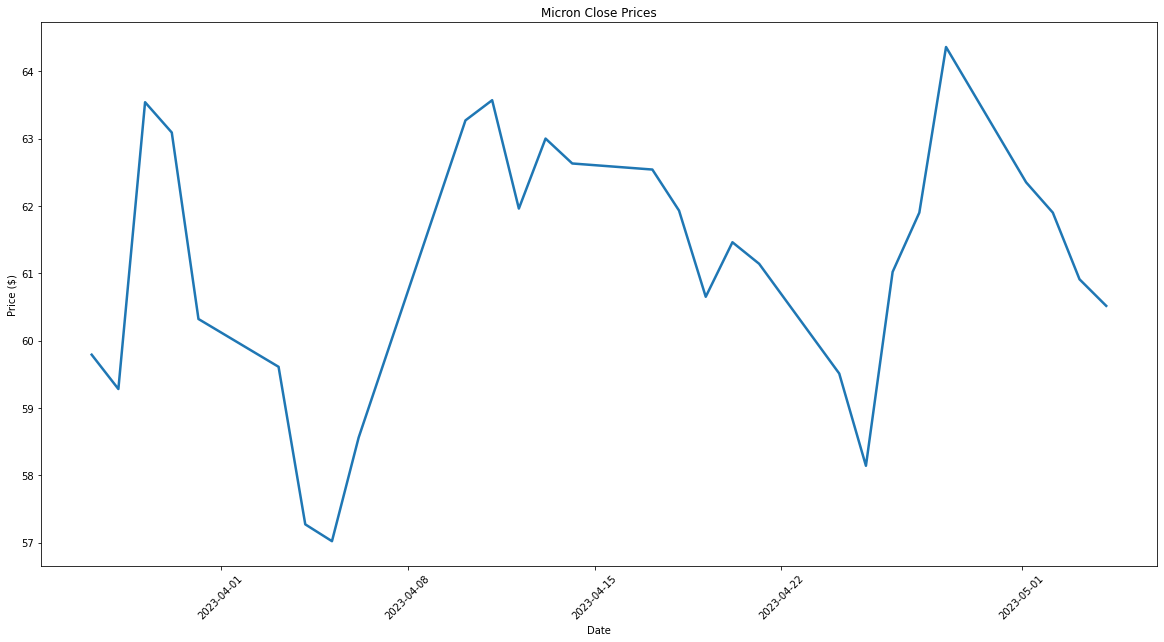

In [45]:
pull_stock_analyze_sentiment('MU', 'Micron', ['Micron',], df)